# Analysis of Toronto City Employee’s Expense Card Transactions

## Introduction

The City of Toronto is transparent about its employee expense card transactions, producing monthly reports available to the public. These transactions are accessible through the City’s Open Data Portal.

## Objectives

The core aims of this analysis include:

1. **Expenditure Characterization**: Understand the expenditure patterns of the City’s Divisions or Cost Centres by exploring metrics like the number and frequency of transactions, their usual amounts, and their dispersion.

2. **Group Identification**: Determine significant groups of Divisions or Cost Centres with similar expense behaviours.

3. **Anomaly Spotting**: Uncover anomalies in the data that warrant further scrutiny.

## Procedures

To accomplish these objectives, the following steps will be undertaken:


### 1. Data Collection and Preprocessing

#### 1.1 Download the data from [Toronto’s Open Data Portal](https://open.toronto.ca/dataset/pcard-expenditures/).


In [25]:
#1.1.1 Import required packages

from io import BytesIO
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import zipfile

mpl.rcParams['figure.dpi'] = 300

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

import warnings

# Suppress the specific warnings
warnings.filterwarnings("ignore")

In [2]:
#1.1.2
# We need to load the PCard Expenditure data into one dataframe so that we can work with them in Python. 
# We have used API for accessing this data. Consuming an API is more efficient and less prone to errors and thus preferred over other ways of loading data. 

base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
url = base_url + "/api/3/action/package_show"
params = {"id": "pcard-expenditures"}

package = requests.get(url, params=params).json()

all_dataframes = []  # List to hold individual DataFrames

# Folder in the same directory as the Jupyter notebook
download_folder = "./"

for idx, resource in enumerate(package["result"]["resources"]):
    if not resource["datastore_active"]:
        resource_url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        resource_metadata = requests.get(resource_url).json()
        download_url = resource_metadata["result"]["url"]
        resource_format = resource["format"].lower()
        filename = download_url.split('/')[-1]  # Extract filename from the URL

        print(f"Resource {idx} - URL: {download_url} - Format: {resource_format}")

# Check if the resource format is zip
if resource_format == "zip":
    response = requests.get(download_url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        # Count the number of .xlsx files within the zip
        xlsx_files_count = sum(1 for file in z.namelist() if file.endswith('.xlsx'))

        for file in z.namelist():
            # Only load xlsx files within the zip
            if file.endswith('xlsx'):
                try:
                    df = pd.read_excel(z.open(file), engine='openpyxl')
                    all_dataframes.append(df)
                except Exception as e:
                    print(f"Error processing file {file} in {download_url}: {e}")

        # Check if the number of .xlsx files matches the length of all_dataframes
        if xlsx_files_count != len(all_dataframes):
            print(f"Warning: Number of xlsx files in the zip ({xlsx_files_count}) doesn't match the number of DataFrames loaded ({len(all_dataframes)}).")

        else:
            # Download and save (overwrite if exists) any other file
            response = requests.get(download_url)
            with open(os.path.join(download_folder, filename), 'wb') as file:
                file.write(response.content)

Resource 0 - URL: https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/ebc3f9c2-2f80-4405-bf4f-5fb309581485/resource/070bdbd3-9bae-4269-b096-e3a8bd7460c8/download/pcard_expenditures_readme.xls - Format: xls
Resource 1 - URL: https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/ebc3f9c2-2f80-4405-bf4f-5fb309581485/resource/d83a5249-fb07-4c38-9145-9e12a32ce1d4/download/expenditures.zip - Format: zip


#### 1.2 Clean and consolidate the data into a single dataframe (`combined_pcard`)

In [3]:
#1.2.1
# Make a copy of all_dataframes that will not affect the original loaded dataframe list.
pcard_dataframe_list = [df.copy() for df in all_dataframes]

# Get columns of the first dataframe as the reference column for consolidation into a single dataset.
reference_columns = pcard_dataframe_list[0].columns

# Flag to indicate if structures are the same
all_same_structure = True

# Iterate through all DataFrames in the list and  Check whether the dataframes in `all_dataframes` list have the same structure and column names
for idx, df in enumerate(pcard_dataframe_list[1:], start=1):  # Start from the second dataframe
    # If columns of current dataframe do not match reference columns
    if not df.columns.equals(reference_columns):
        print(f"DataFrame at index {idx} does not have the same structure as the first DataFrame.")
        all_same_structure = False

DataFrame at index 3 does not have the same structure as the first DataFrame.
DataFrame at index 5 does not have the same structure as the first DataFrame.
DataFrame at index 6 does not have the same structure as the first DataFrame.
DataFrame at index 7 does not have the same structure as the first DataFrame.
DataFrame at index 8 does not have the same structure as the first DataFrame.
DataFrame at index 9 does not have the same structure as the first DataFrame.
DataFrame at index 10 does not have the same structure as the first DataFrame.
DataFrame at index 11 does not have the same structure as the first DataFrame.
DataFrame at index 13 does not have the same structure as the first DataFrame.
DataFrame at index 14 does not have the same structure as the first DataFrame.
DataFrame at index 15 does not have the same structure as the first DataFrame.
DataFrame at index 16 does not have the same structure as the first DataFrame.
DataFrame at index 17 does not have the same structure as 

In [4]:
#1.2.2
#check which columns in the other dataframes that differ from the first dataframe(reference_columns) in the `all_dataframes` list.

# Get columns of the first dataframe as the reference
reference_columns = set(pcard_dataframe_list[0].columns)

# Print the reference columns
print("Reference columns:", ', '.join(reference_columns))
print("")

# Flag to indicate if structures are the same
all_same_structure = True

# Iterate through all DataFrames in the list
for idx, df in enumerate(pcard_dataframe_list[1:], start=1):  # Start from the second dataframe
    current_columns = set(df.columns)
    
    # Find columns that are in the reference but not in the current dataframe
    missing_in_current = reference_columns - current_columns
    # Find columns that are in the current dataframe but not in the reference
    additional_in_current = current_columns - reference_columns
    
    if missing_in_current or additional_in_current:
        all_same_structure = False
        print(f"DataFrame at index {idx} differs from the first DataFrame:")
        
        if missing_in_current:
            print(f"  Missing columns: {', '.join(missing_in_current)}")
        if additional_in_current:
            print(f"  Additional columns: {', '.join(additional_in_current)}")
        print("")


Reference columns: Merchant Type, Division, Cost Centre / WBS Element / Order No., Batch Transaction ID, Transaction Date, G/L Account, Transaction Amt., Original Amount, Merchant Name, Trx Currency, G/L Account Description, Original Currency, Purpose, Merchant Type Description, Card Posting Dt, Cost Centre / WBS Element / Order No. Description

DataFrame at index 3 differs from the first DataFrame:
  Missing columns: Cost Centre / WBS Element / Order No.
  Additional columns: Cost Centre / WBS Element / Order No

DataFrame at index 5 differs from the first DataFrame:
  Missing columns: Trx Currency
  Additional columns: Tr Currency

DataFrame at index 6 differs from the first DataFrame:
  Missing columns: Division, Cost Centre / WBS Element / Order No., Cost Centre / WBS Element / Order No. Description
  Additional columns: Divison, Cost Centre / WBS Element / Order, Cost Centre / WBS Element / Order Description

DataFrame at index 7 differs from the first DataFrame:
  Missing columns

In [5]:
#1.2.3
#By examining the output in 1.2.2 above it looks like the differences are in the column names. Some have spaces, others have fullstop etc.
#Thus we need to normalize the column names and use consistent names through out all the dataframes so that we can merge the data into one combined dataframe.

# `pcard_dataframe_list` is a list of your dataframes
reference_columns = pcard_dataframe_list[0].columns.tolist()

def normalize_column_name(col_name):
    col_name = col_name.lower()  # Convert to lowercase
    col_name = re.sub(r'[^a-z0-9]', '', col_name)  # Remove non-alphanumeric characters
    col_name = col_name.strip()  # Remove leading and trailing spaces
    return col_name

column_mapping = {
    'glaccountdescription': 'gl_account_description',
    'purpose': 'purpose',
    'cardpostingdt': 'card_posting_dt',
    'batchtransactionid': 'batch_transaction_id',
    'trxcurrency': 'trx_currency',
    'trcurrency': 'trx_currency',
    'originalcurrency': 'original_currency',
    'costcentrewbselementordernodescription': 'cost_centre_wbselement_ordernodescription',
    'merchantname': 'merchant_name',
    'transactionamt': 'transaction_amt',
    'costcentrewbselementorderno': 'cost_centre_wbselement_orderno',
    'transactiondate': 'transaction_date',
    'originalamount': 'original_amount',
    'glaccount': 'gl_account',
    'merchanttypedescription': 'merchant_type_description',
    'division': 'division',
    'divison': 'division',
    'merchanttype': 'merchant_type',
    'exptypedesc': 'gl_account_description',
    'costcentrewbselementorder': 'cost_centre_wbselement_orderno',
    'costcentrewbselementorderdescription': 'cost_centre_wbselement_ordernodescription',
    'costcentrewbselementordernodecription': 'cost_centre_wbselement_ordernodescription',
    'costcenterwbselementorder': 'cost_centre_wbselement_orderno',
    'costcenterwbselementorderdescription': 'cost_centre_wbselement_ordernodescription',
    'costcenterwblselementorderdescription': 'cost_centre_wbselement_ordernodescription',
    'costcenterwbselementorder#': 'cost_centre_wbselement_orderno',
    'costcenterwbselementorder#description': 'cost_centre_wbselement_ordernodescription',
}

# Normalize and map columns in each dataframe
for i, df in enumerate(pcard_dataframe_list):
    df.columns = [column_mapping.get(normalize_column_name(col), col) for col in df.columns]

# Adjusting the reference dataframe's columns as well
reference_columns = [column_mapping.get(normalize_column_name(col), col) for col in reference_columns]
pcard_dataframe_list[0].columns = reference_columns

# Combine all dataframes into one dataframe
combined_df= pd.concat(pcard_dataframe_list, ignore_index=True, sort=False)


In [6]:
#1.2.4
#Inspect the structure of the combined dataframe and see if everything checks out.
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220542 entries, 0 to 220541
Data columns (total 16 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   division                                   184088 non-null  object        
 1   batch_transaction_id                       184088 non-null  object        
 2   transaction_date                           184087 non-null  datetime64[ns]
 3   card_posting_dt                            184088 non-null  datetime64[ns]
 4   merchant_name                              184088 non-null  object        
 5   transaction_amt                            218701 non-null  float64       
 6   trx_currency                               218701 non-null  object        
 7   original_amount                            220542 non-null  float64       
 8   original_currency                          220542 non-null  object        
 9   gl_a

In [7]:
#1.2.5
# Drop duplicate rows and reset index
combined_df = combined_df.drop_duplicates().reset_index(drop=True)

In [8]:
#1.2.6
#Check for missing/null values
combined_df.isnull().sum()

division                                     31042
batch_transaction_id                         31042
transaction_date                             31043
card_posting_dt                              31042
merchant_name                                31042
transaction_amt                               1316
trx_currency                                  1316
original_amount                                  0
original_currency                                0
gl_account                                   31042
gl_account_description                       31042
cost_centre_wbselement_orderno               31674
cost_centre_wbselement_ordernodescription    31283
merchant_type                                31062
merchant_type_description                    31042
purpose                                      32428
dtype: int64

In [9]:
#1.2.7
#Treat null values i.e. drop rows where division, batch_transaction_id, merchant_type, card_posting_dt, merchant_name are null
#We are dropping the null values since our analysis and investigation relies heavily on the batch ID and division hence dropping the rows without batch_transation id
# will make the analysis more useful

mask = combined_df[['division','batch_transaction_id','transaction_date', 'merchant_type', 'card_posting_dt','merchant_name']].isnull().all(axis=1)
combined_pcard = combined_df[~mask]
combined_pcard.isnull().sum()

division                                        0
batch_transaction_id                            0
transaction_date                                1
card_posting_dt                                 0
merchant_name                                   0
transaction_amt                                 0
trx_currency                                    0
original_amount                                 0
original_currency                               0
gl_account                                      0
gl_account_description                          0
cost_centre_wbselement_orderno                632
cost_centre_wbselement_ordernodescription     241
merchant_type                                  20
merchant_type_description                       0
purpose                                      1386
dtype: int64

In [10]:
#1.2.8 
# Let us do further clean up by dropping observations with null transaction dates.
combined_pcard = combined_pcard.dropna(subset=['transaction_date'])
combined_pcard.isnull().sum()

division                                        0
batch_transaction_id                            0
transaction_date                                0
card_posting_dt                                 0
merchant_name                                   0
transaction_amt                                 0
trx_currency                                    0
original_amount                                 0
original_currency                               0
gl_account                                      0
gl_account_description                          0
cost_centre_wbselement_orderno                632
cost_centre_wbselement_ordernodescription     241
merchant_type                                  20
merchant_type_description                       0
purpose                                      1386
dtype: int64

In [11]:
#1.2.9
#Let us Inspect the strucutre and shape of our cleaned dataframe
#Note: we have not treated the null values for purpose, cost_centre_wbs_elment_order_no, and cost_centre_wbs_element_order_no_description 
# as this will not affect the outcome of our clustering analysis.
combined_pcard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183736 entries, 0 to 214775
Data columns (total 16 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   division                                   183736 non-null  object        
 1   batch_transaction_id                       183736 non-null  object        
 2   transaction_date                           183736 non-null  datetime64[ns]
 3   card_posting_dt                            183736 non-null  datetime64[ns]
 4   merchant_name                              183736 non-null  object        
 5   transaction_amt                            183736 non-null  float64       
 6   trx_currency                               183736 non-null  object        
 7   original_amount                            183736 non-null  float64       
 8   original_currency                          183736 non-null  object        
 9   gl_a

In [12]:
combined_pcard.nunique()

division                                         58
batch_transaction_id                         183720
transaction_date                               1290
card_posting_dt                                 951
merchant_name                                 15217
transaction_amt                               48568
trx_currency                                      1
original_amount                               47885
original_currency                                22
gl_account                                      303
gl_account_description                          303
cost_centre_wbselement_orderno                 9621
cost_centre_wbselement_ordernodescription      2612
merchant_type                                   321
merchant_type_description                       314
purpose                                       94061
dtype: int64

In [13]:
#1.2.10
#Since we will be focusing mostly on the the Division and GL Account features let us start by cleaning up the Division Column.

#  Strip leading and trailing spaces
combined_pcard['division'] = combined_pcard['division'].str.strip()

# Replace & with AND and then remove special characters (but first check if the value is a string)
combined_pcard['division'] = combined_pcard['division'].apply(
    lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', re.sub(r'&', 'AND', x))
)

# Convert to uppercase
combined_pcard['division'] = combined_pcard['division'].str.upper()

sorted(combined_pcard['division'].unique())

['311 TORONTO',
 'ACCOUNTING SERVICES',
 'AFFORDABLE HOUSING OFFICE',
 'CFO',
 'CHILDRENS SERVICES',
 'CITY CLERKS OFFICE',
 'CITY MANAGER',
 'CITY MANAGERS OFFICE',
 'CITY PLANNING',
 'CORPORATE CONTRACTS',
 'CORPORATE FINANCE',
 'CORPORATE SECURITY',
 'COURT SERVICES',
 'DEPUTY CITY MGR AND CFO',
 'DEPUTY CITY MGR INTERNAL SERVICES',
 'ECONOMIC DEVELOPMENT AND CULTURE',
 'EMERGENCY MEDICAL SERVICES',
 'EMPLOYMENT AND SOCIAL SERVICES',
 'ENGINEERING AND CONSTRUCTION SERVICES',
 'ENVIRONMENT AND ENERGY',
 'ENVIRONMENT AND ENERGY OFFICE',
 'EXECUTIVE MANAGEMENT',
 'FACILITIES MANAGEMENT',
 'FACILITIES MANAGEMENT DIVISON',
 'FINANCE AND ADMINISTRATION',
 'FINANCIAL PLANNING',
 'FIRE SERVICES',
 'FLEET SERVICES',
 'HUMAN RESOURCES',
 'INFORMATION AND TECHNOLOGY',
 'INTERNAL AUDIT',
 'LEGAL SERVICES',
 'LONG TERM CARE HOMES',
 'LONG TERM CARE HOMES AND SERVICES',
 'MUNICIPAL LICENSING AND STANDARDS',
 'OFFICE OF EMERGENCY MANAGEMENT',
 'PARKS FORESTRY AND RECREATION',
 'PENSION PAYROLL AND

In [14]:
#1.2.11
#For divisions with minimal data or significance, we can group them together for clarity.
#This will require us to get more information from the Toronto website on how we can best group the divisions.

#1.2.11.1
#For this analysis we have used the latest Dec 2022 Divisions as highlighted in the Business Expense report.

import requests
import pdfplumber


url = "https://www.toronto.ca/wp-content/uploads/2023/05/9833-Business-Expense-Division-Dec-2022-vFinal-FINAL.pdf"
local_filename = "temp_division_pdf_file.pdf"

# Download the file
response = requests.get(url, stream=True)
with open(local_filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Open the downloaded file with pdfplumber
with pdfplumber.open(local_filename) as pdf:
    # Extract tables from all pages
    all_tables = [page.extract_table() for page in pdf.pages if page.extract_table() is not None]

# Convert the tables to DataFrames
dfs = [pd.DataFrame(table[1:], columns=table[0]) for table in all_tables]

# Remove the temporary PDF file
os.remove(local_filename)

unique_divisions = [x for x in dfs[0]['Division'].str.upper().unique() if x is not None]
sorted_divisions = sorted(unique_divisions)
sorted_divisions

['ACCOUNTING SERVICES',
 'CAPITAL MARKET',
 "CHILDREN'S SERVICES",
 "CITY CLERK'S OFFICE",
 'CITY PLANNING',
 'CORPORATE REAL ESTATE MANAGEMENT',
 'COURT SERVICES',
 'CUSTOMER EXPERIENCE (311 TORONTO)',
 'ECONOMIC DEVELOPMENT AND CULTURE',
 'ENGINEERING & CONSTRUCTION SERVICES',
 'ENVIRONMENT & CLIMATE',
 'EXECUTIVE ADMINISTRATION',
 'FINANCIAL CONTROL AND PROCESS IMPROVEMENT',
 'FLEET SERVICES',
 'HOUSING SECRETARIAT',
 'INDIGENOUS AFFAIRS OFFICE',
 'INSURANCE & RISK MANAGEMENT',
 'INTERNAL AUDIT',
 'LEGAL SERVICES',
 'MUNICIPAL LICENSING AND STANDARDS',
 'OFFICE OF EMERGENCY MANAGEMENT',
 'OFFICE OF THE CHIEF OF STAFF',
 'OFFICE OF THE CISO',
 'OFFICE OF THE CONTROLLER',
 'OFFICE OF THE DEPUTY CITY MANAGER',
 'PARKS, FORESTRY & RECREATION',
 'PENSION, PAYROLL & EMPLOYEE BENEFITS',
 'PEOPLE & EQUITY',
 'POLICY, PLANNING, FINANCE & ADMINISTRATION',
 'PURCHASING & MATERIALS MANAGEMENT',
 'REVENUE SERVICES',
 'SENIORS SERVICES AND LONG-TERM CARE',
 'SHELTER, SUPPORT AND HOUSING ADMINISTR

In [15]:
#1.2.11.2
#Based on the output of 1.2.11.1 let us do mapping of names to standardize the division column.

name_mapping = {
    '311 TORONTO':'CUSTOMER EXPERIENCE (311 TORONTO)',
    'AFFORDABLE HOUSING OFFICE':'SHELTER SUPPORT AND HOUSING ADMINISTRATION',
    'CFO':'POLICY PLANNING FINANCE AND ADMINISTRATION',
    'DEPUTY CITY MGR AND CFO':'OFFICE OF THE DEPUTY CITY MANAGER',
    'DEPUTY CITY MGR INTERNAL SERVICES':'OFFICE OF THE DEPUTY CITY MANAGER',
    'CITY MANAGER':'CITY MANAGERS OFFICE',
    'CORPORATE CONTRACTS':'CORPORATE REAL ESTATE MANAGEMENT',
    'CORPORATE FINANCE':'OFFICE OF THE DEPUTY CITY MANAGER',
    'CORPORATE SECURITY':'CORPORATE REAL ESTATE MANAGEMENT',
    'EMERGENCY MEDICAL SERVICES':'OFFICE OF EMERGENCY MANAGEMENT',
    'EMPLOYMENT AND SOCIAL SERVICES': 'SOCIAL DEVELOPMENT FINANCE AND ADMINISTRATION',
    'ENVIRONMENT AND ENERGY':'ENVIRONMENT AND CLIMATE',
    'ENVIRONMENT AND ENERGY OFFICE':'ENVIRONMENT AND CLIMATE',
    'FACILITIES MANAGEMENT': 'CORPORATE REAL ESTATE MANAGEMENT',
    'FACILITIES MANAGEMENT DIVISON':'CORPORATE REAL ESTATE MANAGEMENT',
    'EXECUTIVE MANAGEMENT':'CITY MANAGERS OFFICE',
    'FINANCE AND ADMINISTRATION':'POLICY PLANNING FINANCE AND ADMINISTRATION',
    'FINANCIAL PLANNING':'POLICY PLANNING FINANCE AND ADMINISTRATION',
    'FIRE SERVICES':'TORONTO FIRE SERVICES',
    'HUMAN RESOURCES': 'PEOPLE & EQUITY',
    'INFORMATION AND TECHNOLOGY':'TECHNOLOGY SERVICES',
    'LONG TERM CARE HOMES':'SENIORS SERVICES AND LONGTERM CARE',
    'LONG TERM CARE HOMES AND SERVICES': 'SENIORS SERVICES AND LONGTERM CARE',
    'PUBLIC HEALTH': 'TORONTO PUBLIC HEALTH',
    'REAL ESTATE SERVICES': 'CORPORATE REAL ESTATE MANAGEMENT',
    'SOLID WASTE MANAGEMENT':'SOLID WASTE MANAGEMENT SERVICES',
    'STRATEGIC AND CORPORATE POLICY':'CITY MANAGERS OFFICE',
    'STRATEGIC COMMUNICATIONS':'CITY MANAGERS OFFICE',
    'TREASURER':'POLICY PLANNING FINANCE AND ADMINISTRATION'
}

# Replace names using the mapping
combined_pcard['division'] = combined_pcard['division'].replace(name_mapping)

combined_pcard['division'].unique()

array(['TORONTO PUBLIC HEALTH', 'ECONOMIC DEVELOPMENT AND CULTURE',
       'PARKS FORESTRY AND RECREATION', 'TORONTO FIRE SERVICES',
       'TRANSPORTATION SERVICES', 'TORONTO WATER',
       'SENIORS SERVICES AND LONGTERM CARE', 'TORONTO PARAMEDIC SERVICES',
       'SHELTER SUPPORT AND HOUSING ADMINISTRATION', 'CITY CLERKS OFFICE',
       'MUNICIPAL LICENSING AND STANDARDS',
       'SOCIAL DEVELOPMENT FINANCE AND ADMINISTRATION',
       'CORPORATE REAL ESTATE MANAGEMENT',
       'POLICY PLANNING FINANCE AND ADMINISTRATION', 'FLEET SERVICES',
       'SOLID WASTE MANAGEMENT SERVICES', 'TECHNOLOGY SERVICES',
       'CITY PLANNING', 'LEGAL SERVICES', 'CHILDRENS SERVICES',
       'ACCOUNTING SERVICES', 'ENGINEERING AND CONSTRUCTION SERVICES',
       'PURCHASING AND MATERIALS MANAGEMENT', 'CITY MANAGERS OFFICE',
       'TORONTO BUILDING', 'REVENUE SERVICES', 'ENVIRONMENT AND CLIMATE',
       'OFFICE OF THE DEPUTY CITY MANAGER',
       'PENSION PAYROLL AND EMPLOYEE BENEFITS',
       'OFFICE O

In [16]:
combined_pcard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183736 entries, 0 to 214775
Data columns (total 16 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   division                                   183736 non-null  object        
 1   batch_transaction_id                       183736 non-null  object        
 2   transaction_date                           183736 non-null  datetime64[ns]
 3   card_posting_dt                            183736 non-null  datetime64[ns]
 4   merchant_name                              183736 non-null  object        
 5   transaction_amt                            183736 non-null  float64       
 6   trx_currency                               183736 non-null  object        
 7   original_amount                            183736 non-null  float64       
 8   original_currency                          183736 non-null  object        
 9   gl_a

### 2. Division Profiling
   - 2.1 Analyze expenditure amounts by division and Generate essential statistics for each Division's expenses such as measures of centrality, dispersion, and frequency.

   - 2.2 Examine other potential characteristics including the diversity of the Cost Centres within each Division, usage of GL Accounts, choice of currencies, among others.
   
   - 2.3 Aggregate the data entirely or present views by month or quarter.
   
Note: For divisions with minimal data or significance, group them together for clarity.


#### 2.1 Characterize expenditure amounts by division and generate essential statistics for each Division's expenses such as measures of centrality, dispersion, and frequency.

2.1.1 Centrality, Dispersion, and Frequency Metrics for each Division's expenses:

In [17]:

# Grouping by division and aggregating transaction amounts
division_stats = combined_pcard.groupby('division')['transaction_amt'].agg(['mean', 'median', 'std', 'count', 'min', 'max']).reset_index()
division_stats['range'] = division_stats['max'] - division_stats['min']

# Rounding to 2 decimal places
cols_to_round = ['mean', 'median', 'std', 'min', 'max', 'range']  # List of columns to round
for col in cols_to_round:
    division_stats[col] = division_stats[col].round(2)

division_stats.sort_values(by='count')


,division,mean,median,std,count,min,max,range
12,INTERNAL AUDIT,293.79,293.79,NaN,1,293.79,293.79,0.00
6,COURT SERVICES,842.28,263.04,1102.37,18,19.66,3384.35,3364.69
7,CUSTOMER EXPERIENCE (311 TORONTO),191.32,169.34,363.13,20,-734.50,827.14,1561.64
18,PENSION PAYROLL AND EMPLOYEE BENEFITS,447.04,450.87,420.37,28,-89.27,1695.00,1784.27
21,PURCHASING AND MATERIALS MANAGEMENT,448.65,286.17,502.46,110,-318.66,2687.12,3005.78
19,PEOPLE & EQUITY,201.52,65.54,386.83,112,-399.80,1199.40,1599.20
16,OFFICE OF THE DEPUTY CITY MANAGER,328.11,143.70,570.55,114,-1400.00,3467.84,4867.84
15,OFFICE OF EMERGENCY MANAGEMENT,372.25,92.94,835.95,151,-446.80,7289.63,7736.43
28,TORONTO BUILDING,613.27,247.69,857.18,188,-2970.67,2998.00,5968.67
0,ACCOUNTING SERVICES,732.83,804.19,730.37,218,-3744.30,3744.30,7488.60


<br/>
<br/>

#### 2.2 Examine other potential characteristics including the diversity of the Cost Centres within each Division, usage of GL Accounts, choice of currencies, among others.

2.2.1 Diversity/Concentration Metrics:

In [18]:
# Calculate total unique values for each category across the entire dataset
total_unique_cost_centres = combined_pcard['cost_centre_wbselement_orderno'].nunique()
total_unique_gl_accounts = combined_pcard['gl_account'].nunique()
total_unique_original_currency = combined_pcard['original_currency'].nunique()
total_unique_merchant_type = combined_pcard['merchant_type'].nunique()
total_unique_purpose = combined_pcard['purpose'].nunique()

# Diversity/Concentration Metrics by Division
def get_diversity_df(groupby_column, total_unique):
    counts = combined_pcard.groupby('division')[groupby_column].nunique()
    percentages = ((counts / total_unique) * 100).round(1) 
    df = pd.DataFrame({
        'Count': counts,
        'Percentage of Total (%)': percentages
    }).sort_values(by='Count', ascending=False)
    return df

div_cost_centre_df = get_diversity_df('cost_centre_wbselement_orderno', total_unique_cost_centres)
div_gl_account_df = get_diversity_df('gl_account', total_unique_gl_accounts)
div_unique_original_currency = get_diversity_df('original_currency', total_unique_original_currency)
div_unique_merchant_type = get_diversity_df('merchant_type', total_unique_merchant_type)
div_purpose_df = get_diversity_df('purpose', total_unique_purpose)


print("Diversity/Concentration Metrics for each Division:")
print("\nNumber of unique Cost Centres:")
display(div_cost_centre_df)
print(" ")
print("\nNumber of unique GL Accounts:")
display(div_gl_account_df)
print(" ")
print("\nNumber of unique Currencies:")
display(div_unique_original_currency)
print(" ")
print("\nNumber of unique Merchant Types:")
display(div_unique_merchant_type)
print(" ")
print("\nNumber of unique Purposes:")
display(div_purpose_df)


Diversity/Concentration Metrics for each Division:

Number of unique Cost Centres:


,Count,Percentage of Total (%)
division,,
CORPORATE REAL ESTATE MANAGEMENT,7010,72.9
PARKS FORESTRY AND RECREATION,1532,15.9
ECONOMIC DEVELOPMENT AND CULTURE,172,1.8
TORONTO PUBLIC HEALTH,125,1.3
TORONTO WATER,105,1.1
SENIORS SERVICES AND LONGTERM CARE,98,1.0
SOLID WASTE MANAGEMENT SERVICES,84,0.9
LEGAL SERVICES,76,0.8
SHELTER SUPPORT AND HOUSING ADMINISTRATION,74,0.8


 

Number of unique GL Accounts:


,Count,Percentage of Total (%)
division,,
PARKS FORESTRY AND RECREATION,219,72.3
ECONOMIC DEVELOPMENT AND CULTURE,147,48.5
TORONTO WATER,138,45.5
SHELTER SUPPORT AND HOUSING ADMINISTRATION,131,43.2
SOLID WASTE MANAGEMENT SERVICES,125,41.3
TORONTO PUBLIC HEALTH,106,35.0
TRANSPORTATION SERVICES,101,33.3
CORPORATE REAL ESTATE MANAGEMENT,99,32.7
TORONTO FIRE SERVICES,95,31.4


 

Number of unique Currencies:


,Count,Percentage of Total (%)
division,,
ECONOMIC DEVELOPMENT AND CULTURE,20,90.9
TORONTO PUBLIC HEALTH,7,31.8
PARKS FORESTRY AND RECREATION,6,27.3
CITY PLANNING,4,18.2
TORONTO WATER,4,18.2
FLEET SERVICES,3,13.6
SENIORS SERVICES AND LONGTERM CARE,3,13.6
SOCIAL DEVELOPMENT FINANCE AND ADMINISTRATION,3,13.6
SOLID WASTE MANAGEMENT SERVICES,3,13.6


 

Number of unique Merchant Types:


,Count,Percentage of Total (%)
division,,
ECONOMIC DEVELOPMENT AND CULTURE,236,73.5
PARKS FORESTRY AND RECREATION,224,69.8
TORONTO FIRE SERVICES,160,49.8
TORONTO WATER,159,49.5
SHELTER SUPPORT AND HOUSING ADMINISTRATION,159,49.5
TORONTO PUBLIC HEALTH,152,47.4
SENIORS SERVICES AND LONGTERM CARE,143,44.5
CORPORATE REAL ESTATE MANAGEMENT,142,44.2
SOCIAL DEVELOPMENT FINANCE AND ADMINISTRATION,117,36.4


 

Number of unique Purposes:


,Count,Percentage of Total (%)
division,,
PARKS FORESTRY AND RECREATION,55494,59.0
ECONOMIC DEVELOPMENT AND CULTURE,8704,9.3
TORONTO WATER,7046,7.5
CORPORATE REAL ESTATE MANAGEMENT,6702,7.1
SOCIAL DEVELOPMENT FINANCE AND ADMINISTRATION,4206,4.5
SENIORS SERVICES AND LONGTERM CARE,3677,3.9
SHELTER SUPPORT AND HOUSING ADMINISTRATION,2546,2.7
SOLID WASTE MANAGEMENT SERVICES,2321,2.5
TORONTO FIRE SERVICES,2280,2.4


#### 2.3 Aggregate across the entire dataset or a view aggregated by month or quarter.


        2.3.1 Average Monthly/Quarterly Expenditure Amount:

In [19]:
# Extracting month and quarter from the transaction_date
combined_pcard['transaction_month'] = combined_pcard['transaction_date'].dt.month
combined_pcard['transaction_quarter'] = combined_pcard['transaction_date'].dt.quarter
combined_pcard['transaction_year'] = combined_pcard['transaction_date'].dt.year

# Monthly aggregation
monthly_expenses = combined_pcard.groupby(['division', 'transaction_month'])['transaction_amt'].mean().round(2).reset_index()

# Quarterly aggregation
quarterly_expenses = combined_pcard.groupby(['division', 'transaction_quarter'])['transaction_amt'].mean().round(2).reset_index()

# Yearly aggregation
yearly_expenses = combined_pcard.groupby(['division', 'transaction_year'])['transaction_amt'].mean().round(2).reset_index()

# Pivot tables with NaN values replaced by empty strings
monthly_pivot = monthly_expenses.pivot_table(index='division', columns='transaction_month', values='transaction_amt', aggfunc='mean').fillna("")
print("Monthly Average by Division:")
display(monthly_pivot)
print("")

Monthly Average by Division:


transaction_month,1,2,3,4,5,6,7,8,9,10,11,12
division,,,,,,,,,,,,
ACCOUNTING SERVICES,534.7,551.99,465.93,956.2,838.83,693.98,821.57,320.39,554.25,799.84,363.92,537.31
CHILDRENS SERVICES,601.7,778.18,668.27,345.7,608.53,566.68,761.47,980.22,655.01,1396.4,591.9,511.68
CITY CLERKS OFFICE,377.63,405.27,346.46,358.99,485.94,660.16,761.88,268.94,438.38,401.86,490.64,503.77
CITY MANAGERS OFFICE,139.88,178.22,322.46,171.53,114.26,66.87,311.76,214.11,107.18,580.75,185.45,305.38
CITY PLANNING,449.77,417.41,584.96,356.59,389.05,601.41,384.99,598.61,166.45,654.42,840.14,948.7
CORPORATE REAL ESTATE MANAGEMENT,197.26,181.98,199.86,205.33,211.39,204.45,187.19,195.75,210.15,206.39,214.36,179.83
COURT SERVICES,1862.57,,,1107.4,502.05,93.77,,,,,894.88,19.66
CUSTOMER EXPERIENCE (311 TORONTO),,142.13,,130.76,,36.58,465.53,,195.28,275.08,1.71,272.16
ECONOMIC DEVELOPMENT AND CULTURE,384.31,342.07,347.66,381.61,246.72,366.09,361.73,319.74,472.17,385.91,341.19,454.0


In [20]:
quarterly_pivot = quarterly_expenses.pivot_table(index='division', columns='transaction_quarter', values='transaction_amt', aggfunc='mean').fillna("")
print("\nQuarterly Average by Division:")
display(quarterly_pivot)
print("")


Quarterly Average by Division:


transaction_quarter,1,2,3,4
division,,,,
ACCOUNTING SERVICES,520.19,836.7,603.19,617.94
CHILDRENS SERVICES,685.86,498.79,743.26,1126.92
CITY CLERKS OFFICE,376.32,511.16,481.95,459.62
CITY MANAGERS OFFICE,225.1,108.72,203.04,295.07
CITY PLANNING,492.23,461.08,329.75,832.13
CORPORATE REAL ESTATE MANAGEMENT,192.8,207.02,197.6,201.04
COURT SERVICES,1862.57,500.64,,676.08
CUSTOMER EXPERIENCE (311 TORONTO),142.13,99.37,285.37,196.56
ECONOMIC DEVELOPMENT AND CULTURE,357.06,329.74,393.4,390.33


In [21]:
yearly_pivot = yearly_expenses.pivot_table(index='division', columns='transaction_year', values='transaction_amt', aggfunc='mean').fillna("")
print("\nYearly Average by Division:")
display(yearly_pivot)


Yearly Average by Division:


transaction_year,2014,2015,2016,2017,2018
division,,,,,
ACCOUNTING SERVICES,,721.84,608.14,798.98,1035.89
CHILDRENS SERVICES,,645.63,903.74,811.99,332.71
CITY CLERKS OFFICE,,407.77,439.22,421.25,606.65
CITY MANAGERS OFFICE,,227.75,226.44,259.83,94.86
CITY PLANNING,,645.06,376.63,447.96,805.94
CORPORATE REAL ESTATE MANAGEMENT,92.01,183.63,200.87,195.49,224.92
COURT SERVICES,,473.39,,2290.34,383.7
CUSTOMER EXPERIENCE (311 TORONTO),,,,237.55,105.48
ECONOMIC DEVELOPMENT AND CULTURE,88.91,345.61,334.61,418.13,331.4


The dataset output above  shows the yearly average employee expenditures for various divisions within the Toronto City government. Here's an interpretation of  sample divisions:

- **Accounting Services:**
  - Expenditures have shown an increasing trend from 2014 to 2017, peaking in 2017 ($1035.89).

- **Children's Services:**
  - Expenditures vary with the highest in 2015 ($903.74) and a significant drop in 2018 ($332.71).

- **Economic Development and Culture:**
  - Expenditures vary, peaking in 2016 ($418.13) and showing fluctuations in other years.

- **Engineering and Construction Services:**
  - Expenditures vary, with noticeable amounts in 2015 ($74.49) and 2016 ($69.07).

- **Environment and Climate:**
  - Expenditures have fluctuations, with the highest in 2017 ($507.70) and variations in other years.

- **Fleet Services:**
  - Expenditures show fluctuations, with relatively stable amounts in 2015 to 2017 and a slight decrease in 2018 ($2414.68).

- **Internal Audit:**
  - Expenditures are present only in 2015 ($293.79).

And so on, Patterns of growth, decline, and fluctuations in expenditure can be observed across divisions and years.

---

### 3. Visualization
   - 3.1 Craft a visual representation showcasing the temporal evolution of expenditures by Division.
   
   - 3.2 Focus primarily on transaction amounts but also consider integrating other insightful metrics.


Note:
   - Combine smaller Divisions for clarity.
   - Showcase multiple visualizations, if necessary, to portray the data most effectively and reveal significant insights.

#### 3.1 Box Plot Analysis showcasing the temporal evolution of expenditures by Division Y-o-Y.

In [26]:
import textwrap

# Get the unique transaction years from the 'transaction_year' column
unique_years = combined_pcard['transaction_year'].unique()
unique_years.sort()

# Get an ordered list of divisions and wrap the text
ordered_divisions = combined_pcard['division'].sort_values().unique()
wrapped_divisions = ['\n'.join(textwrap.wrap(div, width=15)) for div in ordered_divisions]

# Create a figure and axes objects for subplots
fig, axes = plt.subplots(nrows=1, ncols=len(unique_years), figsize=(5*len(unique_years), 30))

# For each year, create a boxplot
for idx, year in enumerate(unique_years):
    yearly_data = combined_pcard[combined_pcard['transaction_year'] == year]
    sns.boxplot(x="transaction_amt", y="division", data=yearly_data, ax=axes[idx], order=ordered_divisions)
    axes[idx].set_title(f'Transaction Year: {year}')
    
    # Remove y-axis labels for plots after the first one and adjust font size
    if idx > 0:
        axes[idx].set_yticklabels([])
        axes[idx].set_ylabel('')
    else:
        axes[idx].set_yticklabels(wrapped_divisions, fontsize=12)

plt.tight_layout()
plt.show()



In [27]:
#3.1.1
#Extract box-plot statistics for further analysis
# Adjust display setting
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

# List to store the results
results = []

# Unique years and divisions
unique_years = combined_pcard['transaction_year'].unique()
unique_years.sort()
ordered_divisions = combined_pcard['division'].sort_values().unique()

# Extract box plot data for each year and division
for year in unique_years:
    for division in ordered_divisions:
        subset = combined_pcard[(combined_pcard['transaction_year'] == year) & (combined_pcard['division'] == division)]
        
        # Compute the required statistics
        min_val = subset['transaction_amt'].min()
        q1 = subset['transaction_amt'].quantile(0.25)
        median = subset['transaction_amt'].median()
        q3 = subset['transaction_amt'].quantile(0.75)
        max_val = subset['transaction_amt'].max()
        
        results.append([year, division, min_val,q1, median, q3, max_val])

# Convert to a DataFrame
df_boxplot_data = pd.DataFrame(results, columns=['Year', 'Division', 'Minimum Expenditures by Division', 'Q1', 'Median Expenditures by Division',
                                                  'Q3', 'Maximum Expenditures by Division'])

# # Pivot the DataFrame with multi-level columns
pivoted = df_boxplot_data.set_index(['Year', 'Division']).unstack('Division')


# Formatting function for currency
def format_currency(val):
    if pd.notna(val):
        try:
            numeric_val = float(val)
            return "{:,.2f}".format(numeric_val)
        except ValueError:
            return str(val)  # If not numeric, return the original value as a string
    else:
        return ""

# Apply the formatting function across the DataFrame
formatted_pivoted = pivoted.applymap(format_currency)

formatted_pivoted.T

Year                                                                                2014       2015        2016       2017       2018
                                 Division                                                                                            
Minimum Expenditures by Division ACCOUNTING SERVICES                                        -199.86   -3,744.30     -35.00      90.46
                                 CHILDRENS SERVICES                                         -499.00       21.30    -165.00  -3,842.00
                                 CITY CLERKS OFFICE                                       -1,000.00     -317.76    -584.25    -475.00
                                 CITY MANAGERS OFFICE                                        -22.60     -899.54     -22.60     -22.60
                                 CITY PLANNING                                                 8.00     -371.52     -14.53       8.00
                                 CORPORATE REAL ESTATE MANAGEMENT                -131.02  -2,527.71   -2,163.00  -1,836.25  -1,798.27
                                 COURT SERVICES                                              103.88                  19.66      31.63
                                 CUSTOMER EXPERIENCE (311 TORONTO)                                                 -734.50      18.59
                                 ECONOMIC DEVELOPMENT AND CULTURE                   6.10  -3,000.00   -3,338.87  -4,234.54  -2,486.00
                                 ENGINEERING AND CONSTRUCTION SERVICES                       -20.00        1.00  -3,334.26           
                                 ENVIRONMENT AND CLIMATE                                    -540.00     -446.35    -231.28    -669.53
                                 FLEET SERVICES                                             -128.00     -130.86  -3,986.00  -4,249.25
                                 INTERNAL AUDIT                                                          293.79                      
                                 LEGAL SERVICES                                             -440.70     -141.25    -785.35    -542.40
                                 MUNICIPAL LICENSING AND STANDARDS                           -30.00     -209.94     -35.46    -599.88
                                 OFFICE OF EMERGENCY MANAGEMENT                   135.60    -446.80      112.99       7.33      24.39
                                 OFFICE OF THE DEPUTY CITY MANAGER                            21.77     -395.55     -11.30  -1,400.00
                                 PARKS FORESTRY AND RECREATION                    -46.15  -2,587.70   -2,332.32  -3,000.00  -2,484.00
                                 PENSION PAYROLL AND EMPLOYEE BENEFITS                       450.87      111.87     -89.27      84.75
                                 PEOPLE & EQUITY                                           1,199.40      -12.77    -399.80           
                                 POLICY PLANNING FINANCE AND ADMINISTRATION                 -524.42     -310.98  -1,017.00      13.57
                                 PURCHASING AND MATERIALS MANAGEMENT                          33.88       33.88    -318.66       7.62
                                 REVENUE SERVICES                                -112.86    -271.06     -777.02    -177.47    -627.77
                                 SENIORS SERVICES AND LONGTERM CARE                35.64  -4,000.00   -2,547.19  -5,022.49  -2,009.13
                                 SHELTER SUPPORT AND HOUSING ADMINISTRATION        16.03    -560.98  -16,150.00    -511.78  -2,830.00
                                 SOCIAL DEVELOPMENT FINANCE AND ADMINISTRATION            -2,639.12   -3,949.35    -847.50  -4,746.00
                                 SOLID WASTE MANAGEMENT SERVICES                   57.57    -337.87   -1,050.90    -640.71    -503.91
                                 TECHNOLOGY SERVICES                                           2.12       28.74   

In [ ]:
# combined_pcard[(combined_pcard['division'] == 'SHELTER SUPPORT AND HOUSING ADMINISTRATION') & (combined_pcard['transaction_year'] == 2016)].sort_values(by='transaction_amt') 
	

#### 3.1.2 Interpratation of the Box plot statistics

- The data shows a dynamic financial landscape with various divisions undergoing changes in expenditures Year on Year. Some divisions show consistent trends(E.g `CITY MANAGER'S OFFICE`), while others fluctuate significantly.(E.g. `ACCOUNTING SERVICES`)

- **Comparative Expenditure:** Divisions such as `TECHNOLOGY SERVICES` and `TORONTO WATER` have similar ranges of expenditures across the years. 

- **Missing Data** Some divisions have missing data for certain years, such as `CUSTOMER EXPERIENCE (311 TORONTO)`. It's important to understand if these divisions were non-operational in those years or if data is simply unavailable.

- **Division Variability** Some divisions have relatively stable expenditures over the years, such as `FLEET SERVICES`. This consistency might indicate a capped expenditure or a budget that's rigorously adhered to.
In contrast, other divisions like `TORONTO PARAMEDIC SERVICES` show significant fluctuation, with the maximum expenditure jumping from $3,000 to over $41,000 within the period. Also, `ECONOMIC DEVELOPMENT AND CULTURE`, show a dramatic increase in their maximum expenditures, from a mere $265 in one year to a whopping $61,842 in another.

- **Potential Anomalies** Many divisions have negative expenditures,  understanding the exact implications would require more context on the G/L accounts and Purpose of purchase. E.g. The `SHELTER SUPPORT AND HOUSING ADMINISTRATION` division shows significant negative expenditures in 2016 of -$16,150 and -$15,246 as a result of refunds for gifts from clients during LD. These negative values requires further investigation with the government on such transactions. On the other end `SHELTER SUPPORT AND HOUSING ADMINISTRATION` has been increasing their maximum expenditures year over year, potentially indicating an expanding scope of services or higher costs among other divisions.

- While some divisions have escalating costs, others are maintaining or reducing their maximum expenditures. The reasons for these could be multifaceted, ranging from inflation, increased operational scope, cost-saving measures, economic events affecting the city, or changes in budget allocations.
    
A deep dive of the specific causes for these expenditure trends, can reveal the factors at play. For a more in-depth understanding and actionable insights, it would be beneficial to collaborate with a financial analyst familiar with the city's budgeting and finance operations or interrogate the data further for more insights.

### 4. Cluster Creation


#### 4.1 Group Divisions with similar behaviours based on the profiles developed in the prior step.

- For clustering we will create new features for our baseline model. We will use KMeans clustering algorithim with silohutte score for measuring the optimal number of clusters we should be having for our  new dataframe(`division_features`).

- Our new data set will comprise of 
    - `division`
    - unique counts of `batch_transaction_id`,`gl_accounts`,`merchant_name` and `purpose`
    -  mean,sum, standard deviation, minium, maximum, median & IQR of the `transaction amounts`
    
- This will help us have a better understanding of the data before we can recommend an improved model. 

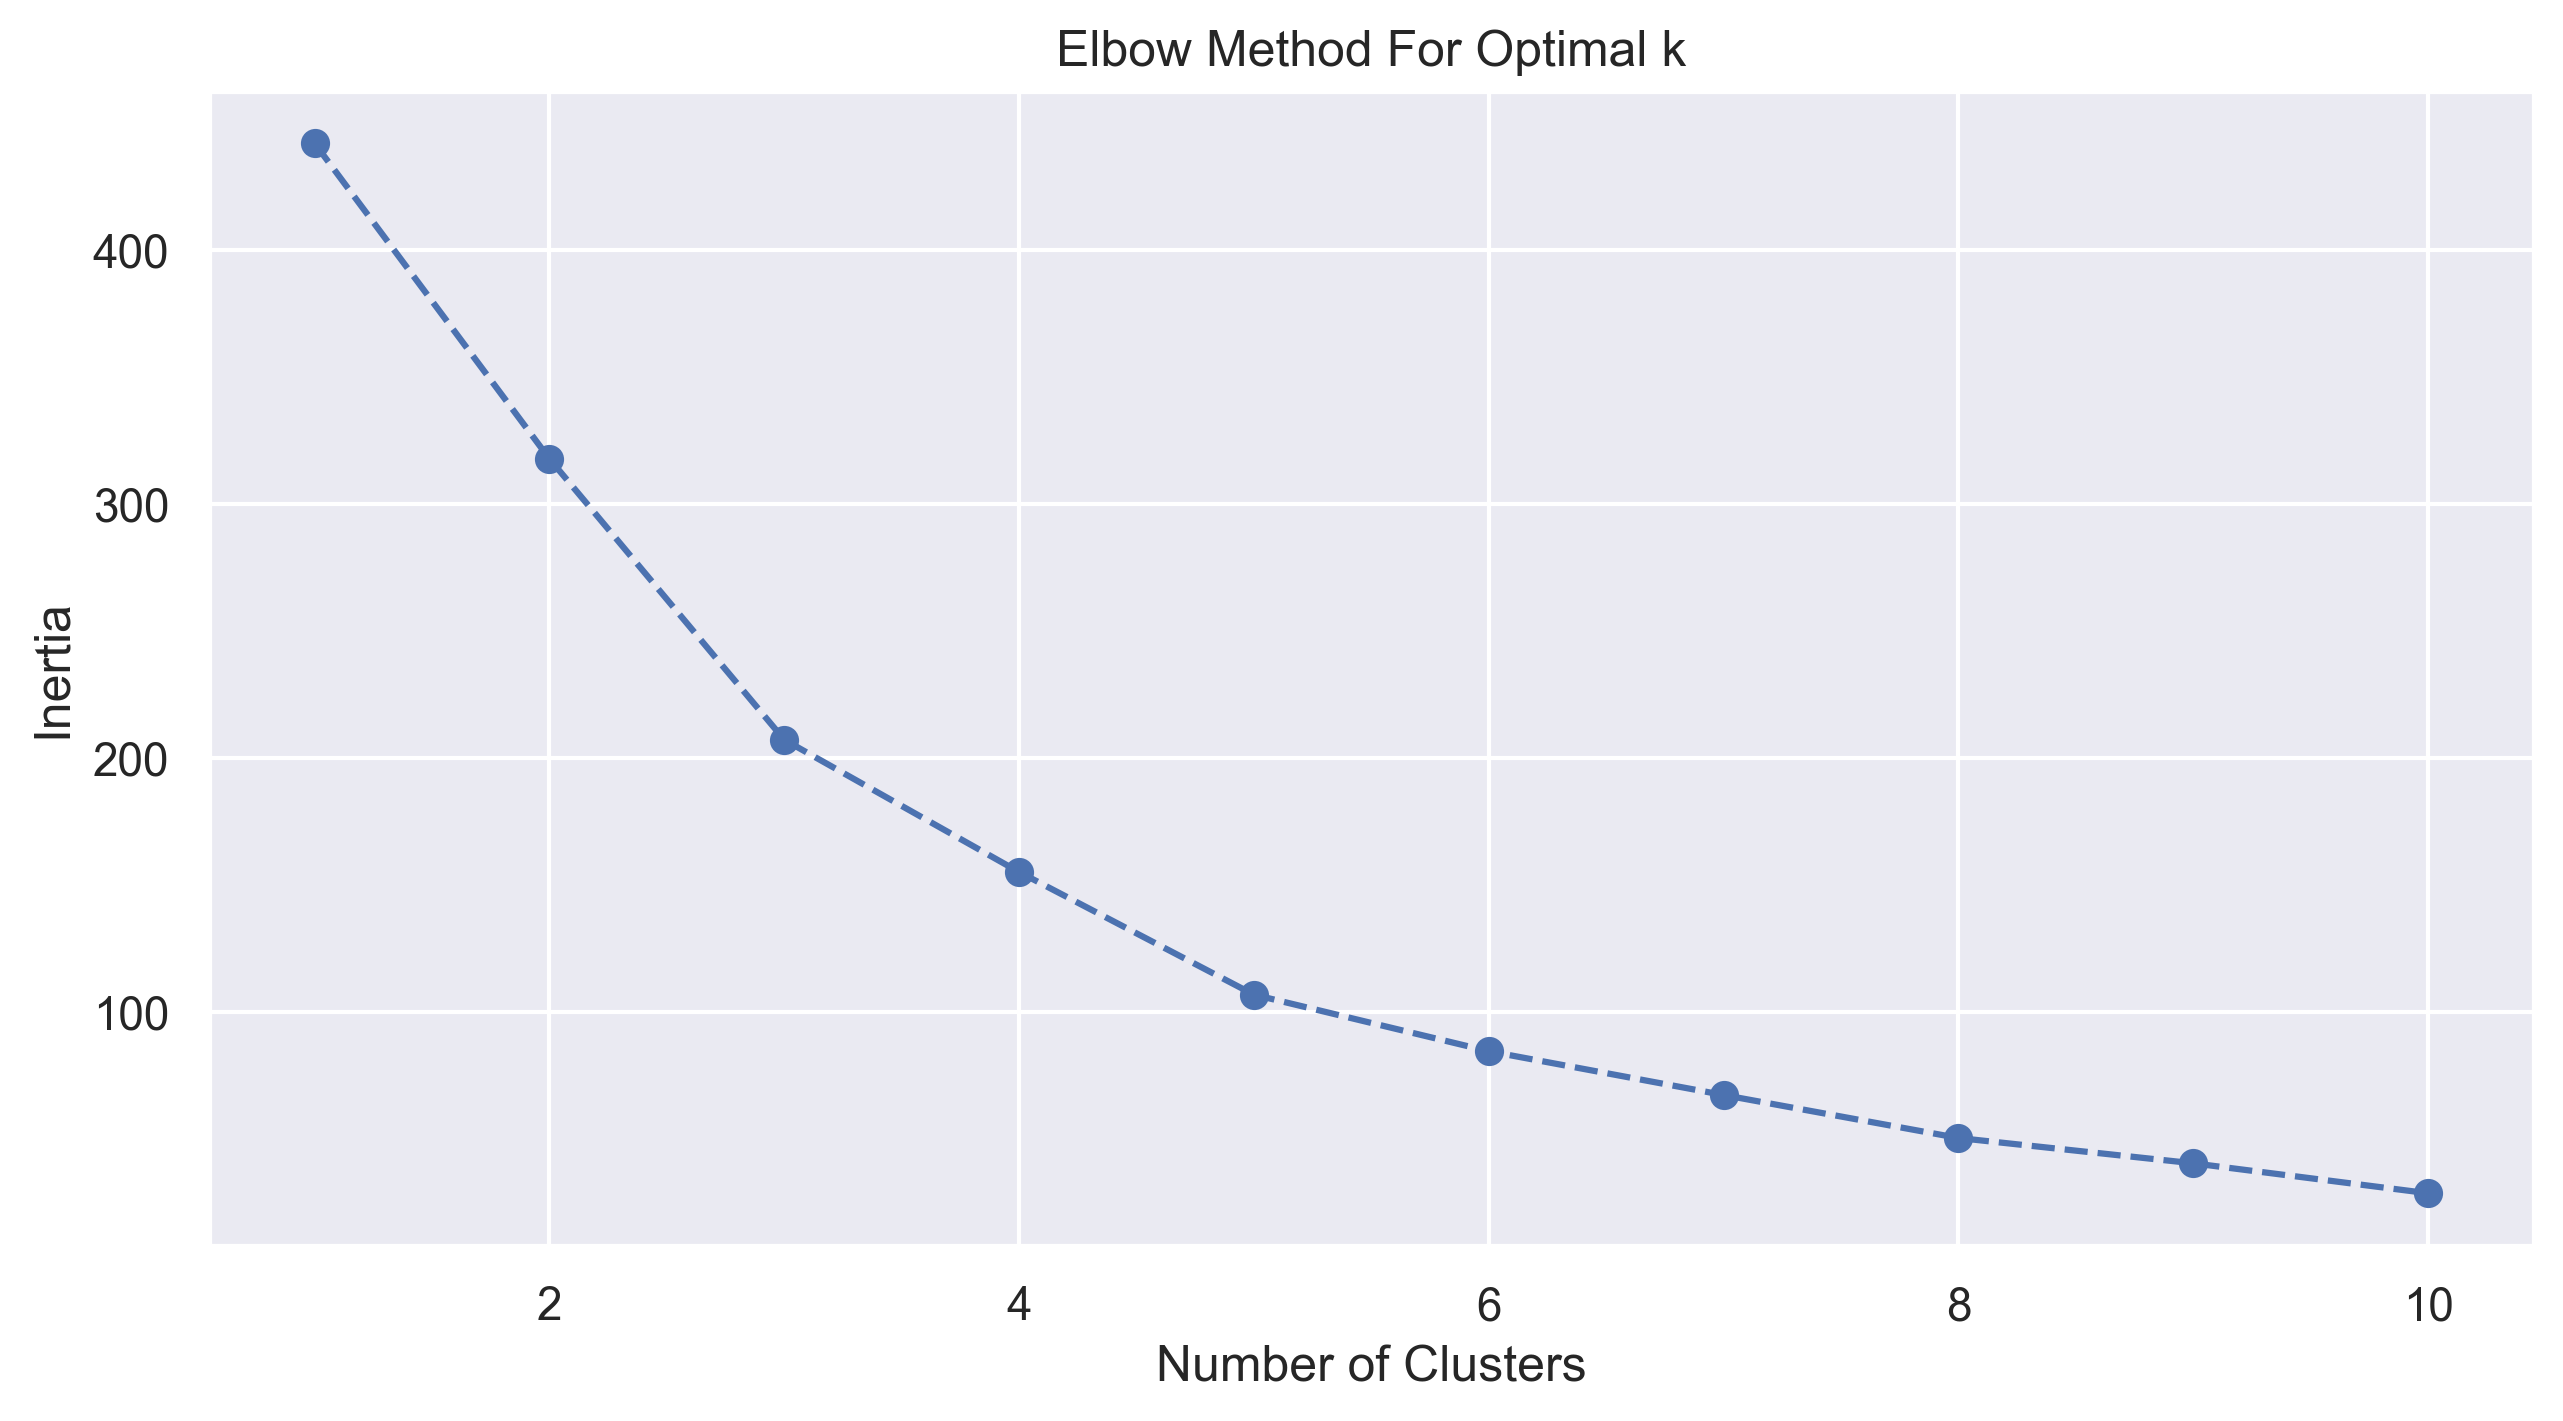

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create features for each division
division_features = combined_pcard.groupby(['division']).agg({
    'batch_transaction_id':'nunique',
    'transaction_amt': ['mean', 'sum', 'std', 'min', 'max', 'median', 
                        lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'gl_account': 'nunique',
    'merchant_name': 'nunique',
    'purpose':'nunique'
}).reset_index()

# Update the columns names after aggregation
division_features.columns = ["_".join(x) for x in division_features.columns.ravel()]
division_features = division_features.rename(columns={'division_': 'division',
                                                      'transaction_amt_<lambda_0>': 'transaction_amt_q1',
                                                      'transaction_amt_<lambda_1>': 'transaction_amt_q3'})

# Compute the IQR
division_features['transaction_amt_iqr'] = division_features['transaction_amt_q3'] - division_features['transaction_amt_q1']

# Handling NaN values
# We are replacing NaN values with the mean of the respective columns
for col in division_features.columns:
    if division_features[col].dtype != 'object':  # Avoid filling for 'division' column
        division_features[col].fillna(division_features[col].mean(), inplace=True)

# Scale the features (excluding 'division')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(division_features.drop(['division'], axis=1))

# Elbow method to find optimal number of clusters
inertia = []
for i in range(1, 11):  # Testing for up to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [29]:
from sklearn.metrics import silhouette_score

# Define the range of clusters
cluster_range = range(4, 15)

# List to store silhouette scores
silhouette_scores = []

# Calculate silhouette scores for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_assignments = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_assignments)
    silhouette_scores.append(silhouette_avg)

# Create a DataFrame to store the results
df_silhouette = pd.DataFrame({
    'Number of Clusters': cluster_range,
    'Silhouette Score': silhouette_scores
})

# Display the DataFrame
df_silhouette

def highlight_max(s):
    """
    Highlight the maximum in a Series yellow.
    """
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the styling function to the DataFrame
styled_df = df_silhouette.style.apply(highlight_max, subset=['Silhouette Score'])

# Display the styled DataFrame
styled_df


,Number of Clusters,Silhouette Score
0,4,0.259066
1,5,0.363032
2,6,0.245566
3,7,0.259539
4,8,0.276728
5,9,0.273881
6,10,0.269128
7,11,0.225037
8,12,0.201369
9,13,0.227903


In [30]:
# Based on the above plot results, we can see that the mean silhouette Coefficient is highest at 5 clusters (0.3630),
# indicating improved model performance and better cluster assignment for each dataset instance.

kmeans = KMeans(n_clusters=5,random_state = 42)
division_features['cluster'] = kmeans.fit_predict(scaled_features)

division_features.sort_values(by='cluster').applymap(format_currency)

,division,batch_transaction_id_nunique,transaction_amt_mean,transaction_amt_sum,transaction_amt_std,transaction_amt_min,transaction_amt_max,transaction_amt_median,transaction_amt_q1,transaction_amt_q3,gl_account_nunique,merchant_name_nunique,purpose_nunique,transaction_amt_iqr,cluster
30,TORONTO PARAMEDIC SERVICES,"2,074.00",295.32,"612,783.56","1,371.50","-2,500.00","41,205.75",62.28,16.00,210.76,77.00,568.00,"1,032.00",194.76,0.00
8,ECONOMIC DEVELOPMENT AND CULTURE,"14,846.00",363.97,"5,403,507.87","1,164.00","-4,234.54","61,842.37",79.63,24.85,316.40,147.00,"4,174.00","8,704.00",291.55,0.00
24,SHELTER SUPPORT AND HOUSING ADMINISTRATION,"3,085.00",805.01,"2,483,463.91","2,090.86","-16,150.00","25,000.00",265.21,66.67,745.39,131.00,749.00,"2,546.00",678.72,0.00
22,REVENUE SERVICES,240.00,502.82,"120,676.44","2,593.37",-777.02,"39,493.50",131.06,48.79,408.30,40.00,98.00,213.00,359.51,0.00
17,PARKS FORESTRY AND RECREATION,"98,337.00",199.38,"19,606,012.25",341.98,"-3,000.00","6,162.12",81.81,33.48,218.47,219.00,"5,743.00","55,494.00",184.99,1.00
16,OFFICE OF THE DEPUTY CITY MANAGER,114.00,328.11,"37,404.59",570.55,"-1,400.00","3,467.84",143.69,29.06,446.78,28.00,76.00,106.00,417.72,2.00
31,TORONTO PUBLIC HEALTH,"4,936.00",387.27,"1,911,541.00",733.21,"-3,000.00","9,945.70",145.00,39.50,447.48,106.00,"1,619.00",975.00,407.98,2.00
29,TORONTO FIRE SERVICES,"4,319.00",293.61,"1,268,108.36",613.57,"-2,272.69","18,958.50",77.20,50.59,282.79,95.00,959.00,"2,280.00",232.20,2.00
28,TORONTO BUILDING,188.00,613.27,"115,294.34",857.18,"-2,970.67","2,998.00",247.69,68.47,852.60,28.00,66.00,155.00,784.13,2.00
27,TECHNOLOGY SERVICES,241.00,312.73,"75,367.47",601.50,-62.09,"3,164.00",136.70,74.09,266.58,18.00,86.00,172.00,192.49,2.00


#### 4.2 Describe each cluster and elucidate its unique attributes.

In [31]:
clusters = division_features['cluster'].nunique()
cluster_descriptions = []

for cluster in range(clusters):
    cluster_data = division_features[division_features['cluster'] == cluster]
    
    # Fetching basic stats
    mean_transaction_amt = cluster_data['transaction_amt_mean'].mean()
    median_transaction_amt = cluster_data['transaction_amt_median'].mean()
    max_transaction_amt = cluster_data['transaction_amt_max'].max()
    min_transaction_amt = cluster_data['transaction_amt_min'].min()
    num_divisions = cluster_data['division'].nunique()
    
    description = {
        "Cluster": cluster,
        "Num_Divisions": num_divisions,
        "Avg_Mean_Transaction": mean_transaction_amt,
        "Avg_Median_Transaction": median_transaction_amt,
        "Max_Transaction": max_transaction_amt,
        "Min_Transaction": min_transaction_amt
    }
    
    cluster_descriptions.append(description)

# Convert list of dictionaries to DataFrame
description_df = pd.DataFrame(cluster_descriptions)

description_df.applymap(format_currency)


,Cluster,Num_Divisions,Avg_Mean_Transaction,Avg_Median_Transaction,Max_Transaction,Min_Transaction
0,0.00,4.00,491.78,134.54,"61,842.37","-16,150.00"
1,1.00,1.00,199.38,81.81,"6,162.12","-3,000.00"
2,2.00,23.00,305.60,122.63,"18,958.50","-5,022.49"
3,3.00,1.00,"2,711.51",491.00,"10,000.00","-4,249.25"
4,4.00,5.00,593.48,435.94,"4,294.00","-3,842.00"


**Cluster 0 (`TORONTO PARAMEDIC SERVICES`,`ECONOMIC DEVELOPMENT AND CULTURE`,`SHELTER SUPPORT AND HOUSING ADMINISTRATION`,`REVENUE SERVICES`):**
- **Divisions:** This cluster comprises 4 divisions.
- **Transaction Attributes:** Divisions in this cluster have an average mean transaction of approximately $491.78 and a median transaction of about $134.54. The range of transaction amounts in this cluster is quite wide, spanning from -$16,150.00 to a substantial $61,842.37.
- **Unique Attribute:** Cluster 0 represents divisions with diverse transaction behaviors. These divisions handle a wide range of transaction values, possibly indicating occasional high-value transactions.

**Cluster 1(`PARKS FORESTRY AND RECREATION`):**
- **Divisions:** This cluster is unique as it contains only 1 division.
- **Transaction Attributes:** The mean transaction for this division is around $199.38, with a median transaction of $81.81. Transactions in this division range from -$3,000.00 to $6,162.12.
- **Unique Attribute:** Despite having only one division, this cluster stands out due to the division's modest transaction values. However, the narrower range of transactions compared to other clusters is notable.

**Cluster 2 (`OTHERS`):**
- **Divisions:** The largest cluster, containing 23 divisions.
- **Transaction Attributes:** On average, divisions in this cluster have a mean transaction amount of about $305.60, with a median transaction of $122.63. Transaction values within this cluster range from -$5,022.49 to $18,958.50.
- **Unique Attribute:** Cluster 2, despite having the most divisions, deals with a wide variety of transactions but doesn't have the broadest range of transaction values among the clusters.

**Cluster 3(`FLEET SERVICES`):**
- **Divisions:** Similar to Cluster 1, Cluster 3 has only 1 division.
- **Transaction Attributes:** The mean transaction for this division is notably high at approximately $2,711.51, with a median transaction of $491.00. Transactions here span from -$4,249.25 to $10,000.00.
- **Unique Attribute:** With a solitary division, Cluster 3's standout characteristic is its high mean transaction value, suggesting that this specific division handles larger monetary transactions.

**Cluster 4(`COURT SERVICES`,`INTERNAL AUDIT`,`PENSION PAYROLL AND EMPLOYEE BENEFITS`,`CHILDRENS SERVICES`,`ACCOUNTING SERVICES`):**
- **Divisions:** This cluster comprises 5 divisions.
- **Transaction Attributes:** Divisions in Cluster 4 have an average mean transaction amount of around $593.48. The median transaction for these divisions is approximately $435.94. Transactions within this cluster range from a minimum of -$3,842.00 to a maximum of $4,294.00.
- **Unique Attribute:** Cluster 4 showcases divisions with moderate transaction values, representing typical and routine transactions, given the relatively narrow range between the maximum and minimum transaction amounts.

In summary, the analysis of the updated dataset reveals varying transaction behaviors across the different clusters. Clusters 0 and 4, each consisting of multiple divisions, represent more common transaction patterns. Cluster 1 exhibits a broader range of transaction values, while Clusters 2 and 3 highlight unique transaction behaviors of individual divisions.

### 5. Anomaly Detection
   - 5.1 Utilizing the profiles, pinpoint Divisions that manifest anomalous behaviours.
   - 5.2 Further subdivide by clusters to highlight any irregularities if beneficial.

         PC1       PC2                                    division
8   3.472690  1.950503            ECONOMIC DEVELOPMENT AND CULTURE
11 -5.195409  8.652914                              FLEET SERVICES
17  9.493510  4.338936               PARKS FORESTRY AND RECREATION
24  0.135498  3.023488  SHELTER SUPPORT AND HOUSING ADMINISTRATION


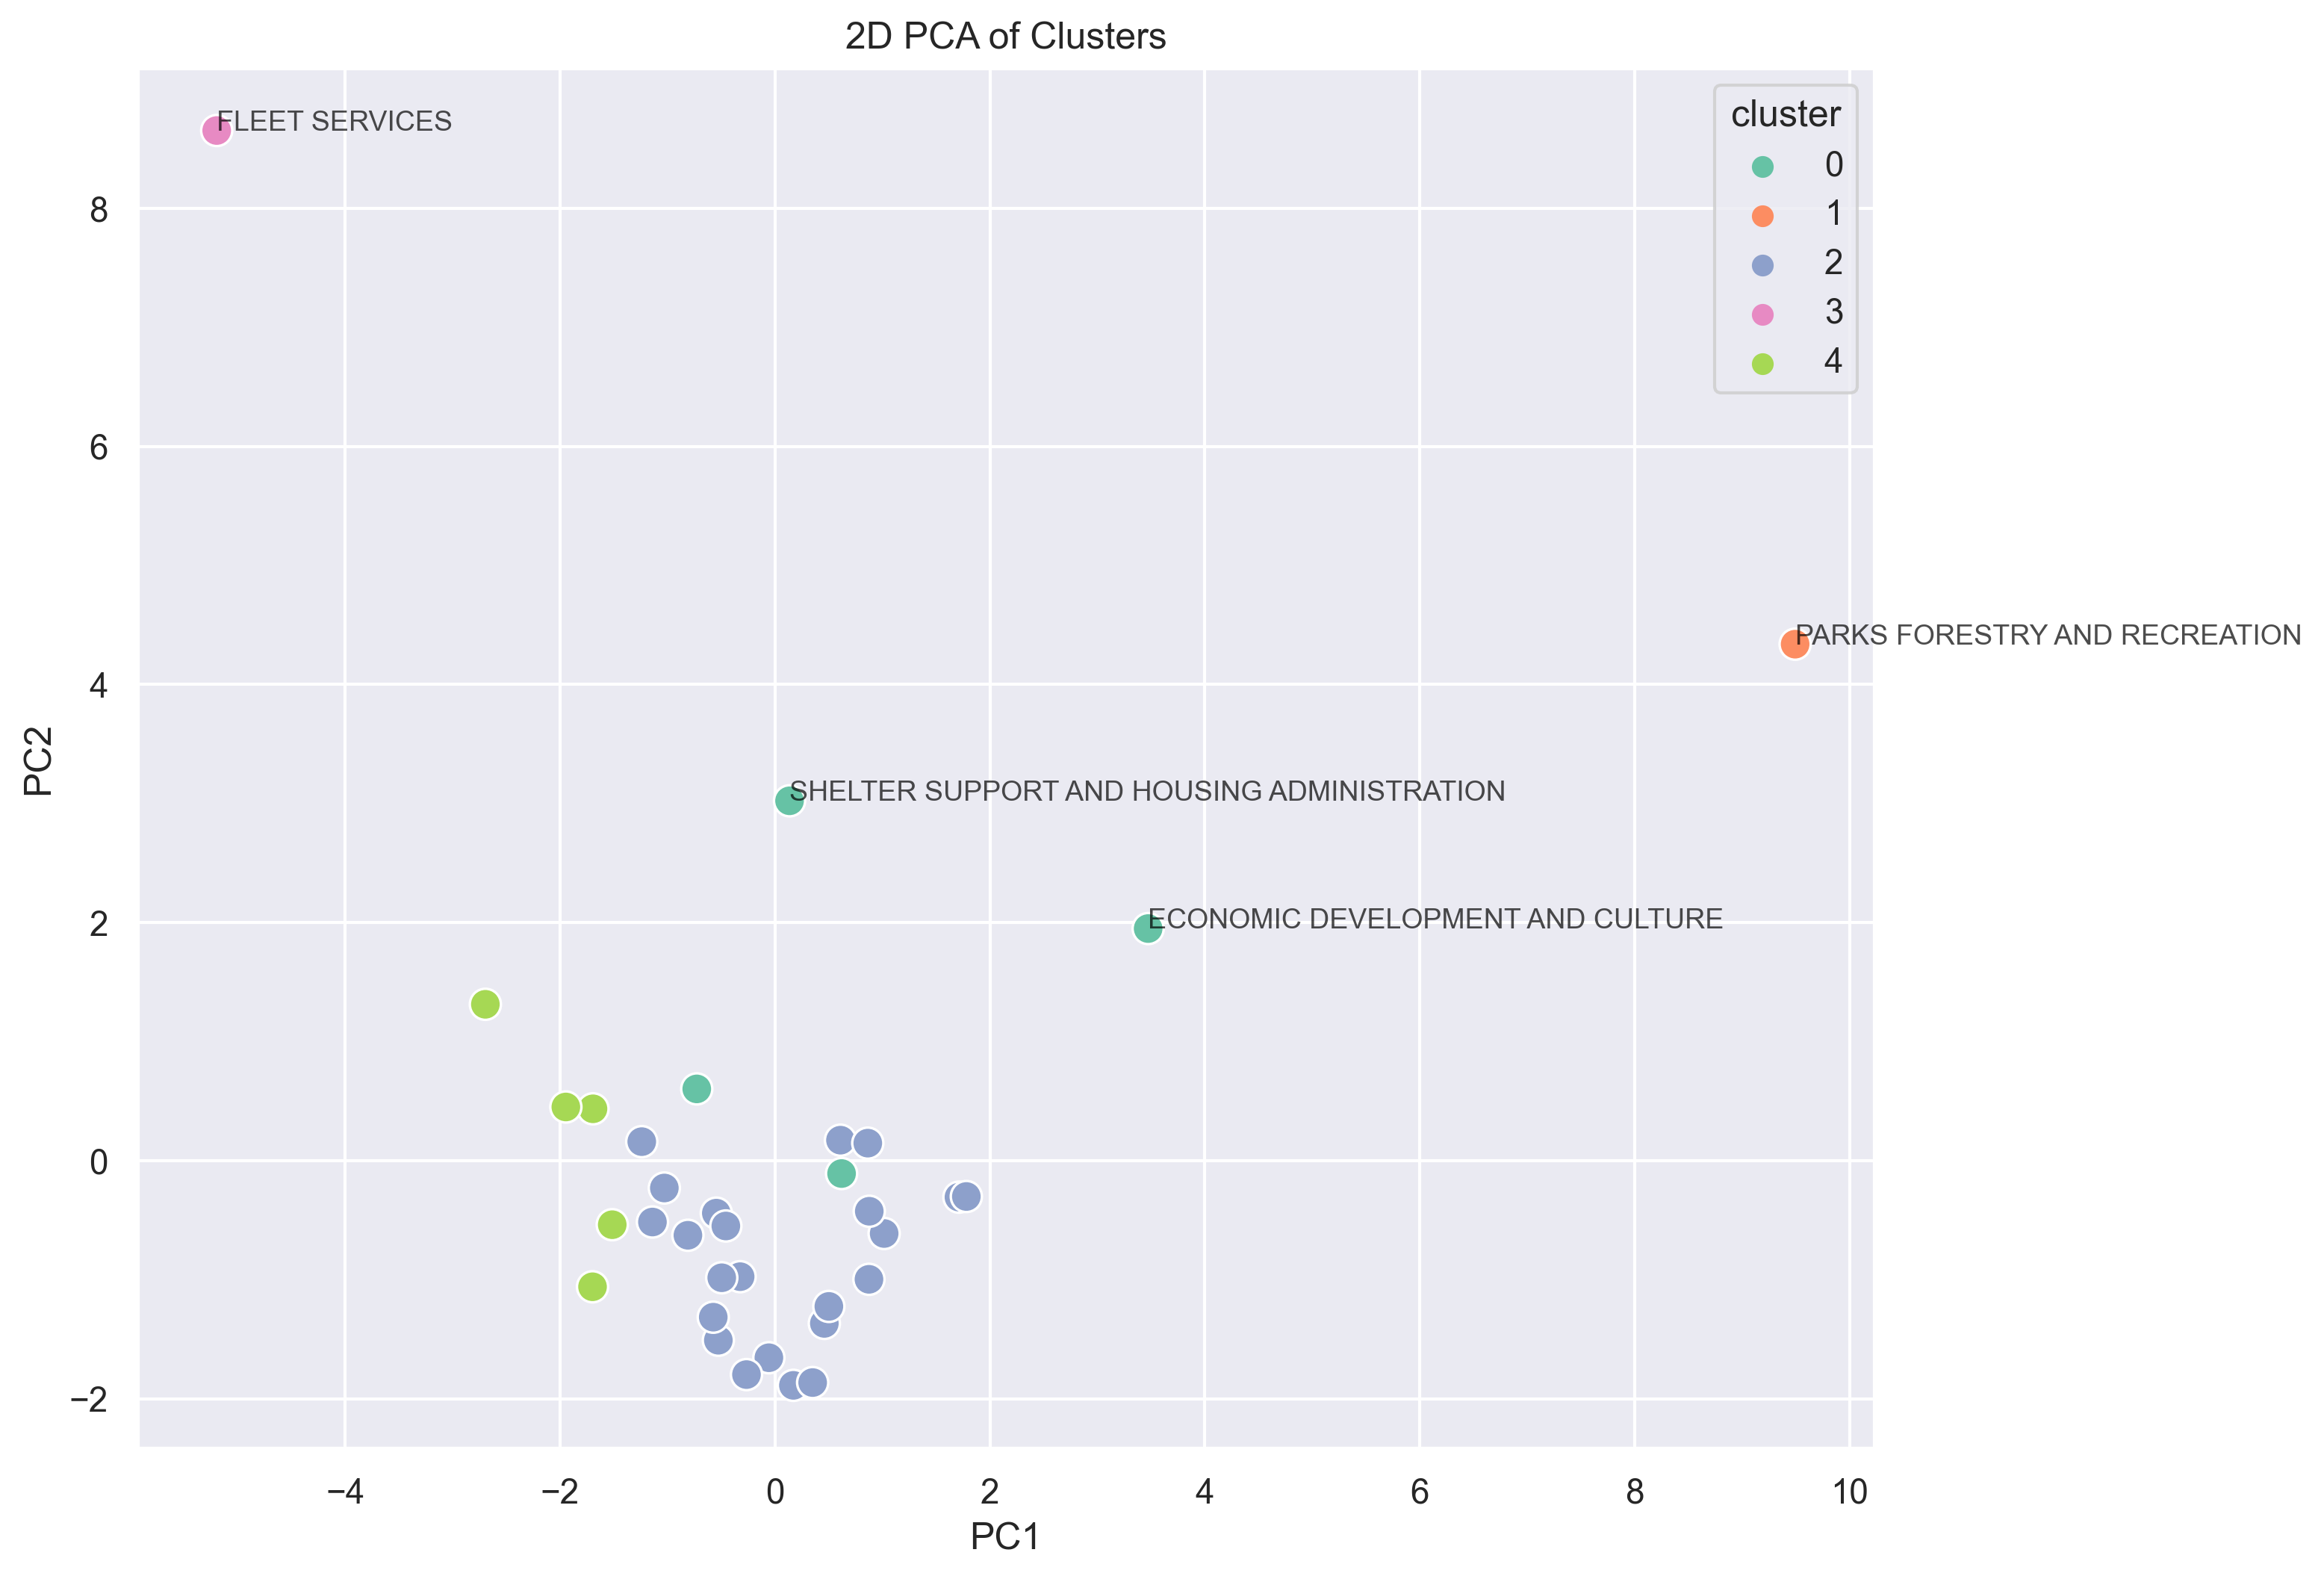

In [32]:
# To identify anomalous behavior in divisions based on the provided data, we'll follow a step-by-step approach:

# 1. **Data Standardization**: Since different features have different scales, it's essential to standardize the data to ensure equal weightage to all features.
   
# 2. **PCA for Visualization**: Principal Component Analysis (PCA) can be used to reduce the dimensionality of the data and visualize it in 2D or 3D space to spot any potential outliers or anomalous behavior.
   
# 3. **IQR Method**: We can use the Interquartile Range (IQR) method to identify outliers in the principal components. The IQR is a measure of statistical spread between the 25th percentile (Q1) and the 75th percentile (Q3). Anything outside the range `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]` can be considered as an anomaly or outlier.

# 4. **Analysis and Interpretation**: Based on the results, we can then identify divisions that show anomalous behavior.

# Let's walk through the process:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Standardization
features = division_features.drop(['division', 'cluster'], axis=1)
scaled_features = StandardScaler().fit_transform(features)

# Step 2: PCA for Visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['division'] = division_features['division']

# Step 3: IQR Method for anomaly detection
Q1 = principal_df[['PC1', 'PC2']].quantile(0.25)
Q3 = principal_df[['PC1', 'PC2']].quantile(0.75)
IQR = Q3 - Q1
filter = (principal_df[['PC1', 'PC2']] < (Q1 - 1.5 * IQR)) | (principal_df[['PC1', 'PC2']] > (Q3 + 1.5 * IQR))

anomalous_divisions_df = principal_df[filter.any(axis=1)]

# Display anomalous divisions
print(anomalous_divisions_df)

# Attach cluster labels from KMeans
principal_df['cluster'] = division_features['cluster']

# Plotting the 2D PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=principal_df, palette='Set2', s=100)

# Annotate each anomalous division with its name
for _, row in anomalous_divisions_df.iterrows():
    plt.annotate(row['division'], (row['PC1'], row['PC2']), fontsize=9, alpha=0.7, color='black')

plt.title('2D PCA of Clusters')
plt.show()



#### 5.3 Rank Divisions by their "abnormality", opting for criteria like the Top 10 Divisions or the Top 10% based on specific metrics.

We considered `Distance from the Median` approach due to it's simplicity of use:


1. **Distance from the Median:** One common method to rank the abnormality of divisions is to calculate the distance of each point from the median (or mean) of the PCA components. The idea is that the farther a division is from the central tendency of the data, the more abnormal it is.

In [33]:
# Calculate the median for PC1 and PC2
median_PC1 = principal_df['PC1'].median()
median_PC2 = principal_df['PC2'].median()

# Compute the distance of each division from the median of the PCA components
anomalous_divisions_df['distance_from_median'] = np.sqrt((anomalous_divisions_df['PC1'] - median_PC1)**2 + 
                                                         (anomalous_divisions_df['PC2'] - median_PC2)**2).round(2)

# Rank the divisions based on the distance
anomalous_divisions_df = anomalous_divisions_df.sort_values(by='distance_from_median', ascending=False)

# Reset index, drop old index, and start counting from 1
anomalous_divisions_df = anomalous_divisions_df[['division', 'distance_from_median']].reset_index(drop=True)
anomalous_divisions_df.index = anomalous_divisions_df.index + 1

# Display the ranked anomalous divisions
anomalous_divisions_df


,division,distance_from_median
1,PARKS FORESTRY AND RECREATION,10.91
2,FLEET SERVICES,10.36
3,ECONOMIC DEVELOPMENT AND CULTURE,4.48
4,SHELTER SUPPORT AND HOUSING ADMINISTRATION,3.53


#### 5.4 Recommend a strategy to differentiate between "normal" and "abnormal" Divisions through sampling.

Using sampling to differentiate between normal and abnormal divisions requires a statistical approach that involves examining the distribution of data and determining whether a division's characteristics fall within expected ranges. Here's a strategy we can follow after we have done procdure 1 to 5 above:

1. **Define `Normal` and `Abnormal` Criteria:**
   - We need to decide on criteria that define what is considered `normal` and `abnormal` for divisions based on the specific attributes we're analyzing (e.g., transaction amounts).
   - This could involve setting thresholds based on historical data.

2. **Sampling:**
   - Select a sample of divisions from our dataset. The sample size will depend on the size of our dataset and the desired level of confidence.
   - we can use random sampling or other sampling methods based on our analysis goals.

3. **Compare with Criteria:**
   - Compare the sample statistics with the predefined criteria for `normal` and `abnormal` divisions.
   - Divisions that fall within the expected ranges are considered `normal`, while those that significantly deviate from the criteria may be `abnormal`.

4. **Statistical Tests:**
   - Perform statistical tests if necessary to quantify the differences between sample statistics and criteria.
   - For example, we can use Z-tests, T-tests, or other relevant tests to compare means or other attributes.

5. **Visualization:**
   - Visualize the sample data and their distributions to see how they align with our `normal` and `abnormal` criteria.

6. **Decision Making:**
   - Based on our analysis, make decisions about whether each division is considered `normal` or `abnormal` according to the predefined criteria.
   - Keep in mind that `abnormal` divisions might need further investigation to understand the underlying reasons for deviations.

7. **Iterative Process:**
    - This process may require multiple iterations as we refine our criteria, sample size, or analysis methods.

**Note:** What's considered `normal` and `abnormal` can depend on the context and business requirements. Using statistical techniques and sampling can help us identify divisions that exhibit unusual behaviors or characteristics, leading to a more data-driven decision-making process.